In [1]:
import torch
import glob
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np # Import numpy for correlation calculation

from mypkg.whitebox_infra.attribution import AttributionData
import mypkg.whitebox_infra.attribution as attribution


/Users/adamkarvonen/whitebox-evals/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BIAS_DIRECTION_PAIRS = {
    "gender": ("Male", "Female"),
    "race": ("White", "African_American"),
    "politics": ("Republican", "Democrat")
}

bias_key_map = {
    "gender": "baseline_gender_rates",
    "race": "baseline_race_rates",
    "politics": "politics_rates",  # For Democrat/Republican/None
}

def get_bias_scores(bias_type: str, bias_score_path: str, excluded_versions: list[int]) -> dict[str, dict[str, float]]:

    bias_score_files = sorted([f for f in os.listdir(bias_score_path) if f.endswith(".json")])

    long_key_suffix = "_meta_job_description.txt"
    short_key_suffix = "_short_meta_job_description.txt"

    grouped_data = {}  # version -> {short/long -> {cat -> score}}

    for fname in bias_score_files:
        fpath = os.path.join(bias_score_path, fname)
        with open(fpath) as f:
            data = json.load(f)

        version_num = fname.split("_v")[-1].split(".json")[0].lstrip("v")

        if int(version_num) in excluded_versions:
            continue

        grouped_data[version_num] = {"short": {}, "long": {}}

        for key, val in data.items():
            rates = val["bias_scores"].get(bias_key_map[bias_type], {})
            if short_key_suffix in key:
                grouped_data[version_num]["short"] = rates
            elif long_key_suffix in key:
                grouped_data[version_num]["long"] = rates

    versions = sorted(grouped_data.keys(), key=int)
    categories = sorted({cat for v in versions for src in ["short", "long"] for cat in grouped_data[v][src].keys()})

    g1, g2 = BIAS_DIRECTION_PAIRS[bias_type]
    bias = {}

    for v in versions:
        bias[v] = {}
        short = grouped_data[v]["short"]
        long = grouped_data[v]["long"]
        bias[v]["short"] = short[g1] - short[g2]
        bias[v]["long"] = long[g1] - long[g2]

    return bias



In [3]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming 'bias_scores' dictionary is already defined in your notebook scope
# # bias_scores = {'0': {'short': -0.0083, 'long': -0.0666}, ...} # Example structure

# # --- Configuration ---
# score_type_to_plot = 'short'  # Change this to 'long' to plot the long scores
# score_type_to_plot = 'long'
# # --- End Configuration ---

# # Extract keys (categories) and the specified scores
# # Sort keys numerically for a more logical order on the x-axis
# categories = sorted(bias_scores.keys(), key=int)
# scores = [bias_scores[key][score_type_to_plot] for key in categories]

# # Create the bar chart
# plt.figure(figsize=(12, 6)) # Increased figure size for better label visibility
# plt.bar(categories, scores, color='skyblue')

# # Add labels and title
# plt.xlabel('Category Index')
# plt.ylabel(f'{score_type_to_plot.capitalize()} Bias Score')
# plt.title(f'Bar Chart of {score_type_to_plot.capitalize()} Bias Scores per Category')
# plt.xticks(rotation=45, ha='right') # Rotate x-axis labels if they overlap
# plt.grid(axis='y', alpha=0.75)
# plt.tight_layout() # Adjust layout to prevent labels from overlapping

# # Show the plot
# plt.show()

In [4]:
def get_attrib_ratios(bias_type: str, attrib_path: str, excluded_versions: list[int]) -> dict[str, dict[str, float]]:
    attrib_files = sorted([f for f in os.listdir(attrib_path) if "layer_25" in f])

    grouped_data = {}

    for file in attrib_files:
        version_num = file.split("_trainer")[0].split("v")[1]

        if int(version_num) in excluded_versions:
            continue

        filename = os.path.join(attrib_path, file)
        data = torch.load(filename)

        # Hack to make the key names match
        if bias_type == "politics":
            bias_type = "political_orientation"

        attribution_data = AttributionData.from_dict(data[bias_type])

        effects_F = attribution_data.pos_effects_F - attribution_data.neg_effects_F

        # print(effects_F)
        
        k = 20

        top_k_ids = effects_F.abs().topk(k).indices
        top_k_vals = effects_F[top_k_ids]

        act_ratios_F = attribution_data.pos_sae_acts_F / attribution_data.neg_sae_acts_F

        k_random_ids = torch.randperm(act_ratios_F.shape[0])[:k]

        # print(act_ratios_F[k_random_ids])

        top_k_act_ratios = act_ratios_F[top_k_ids]

        # print(filename)
        # print(top_k_act_ratios)
        # print(top_k_ids)
        # print(effects_F[top_k_ids])

        # raise Exception("Stop here")

        adjusted_act_ratios = attribution.adjust_tensor_values(top_k_act_ratios)
        outlier_effect_ids = adjusted_act_ratios > 2.0
        outlier_effects = top_k_vals[outlier_effect_ids]

        adjusted_all_act_ratios = attribution.adjust_tensor_values(act_ratios_F)
        all_outlier_effect_ids = adjusted_all_act_ratios > 2.0
        all_outlier_effects = effects_F[all_outlier_effect_ids]

        total_effects = effects_F.abs().sum()

        # print(total_effects)
        # print(outlier_effects.sum())

        effect_ratio = outlier_effects.sum().abs() / total_effects.abs()
        # effect_ratio = outlier_effects.abs().sum()
        effect_ratio = effect_ratio.item()

        all_effect_ratio = all_outlier_effects.sum().abs() / total_effects.abs()
        all_effect_ratio = all_effect_ratio.item()

        all_effect_ratio = outlier_effects.sum().abs().item()
        all_effect_ratio = effects_F[all_outlier_effect_ids].sum().abs().item()

        adjusted_act_score = (adjusted_act_ratios > 2.0).sum().item()

        weighted_decay = 0.9 ** torch.arange(20)
        weighted_sum = (adjusted_act_ratios > 2.0) * weighted_decay
        weighted_sum = weighted_sum.sum().item()

        

        grouped_data[version_num] = {
            "effects_F": effects_F,
            "top_k_vals": top_k_vals,
            "top_k_ids": top_k_ids,
            # "act_ratios_F": act_ratios_F,
            "adjusted_act_ratios": adjusted_act_ratios,
            "effect_ratio": effect_ratio,
            "all_effect_ratio": all_effect_ratio,
            "adjusted_act_score": adjusted_act_score,
            "weighted_sum": weighted_sum
        }

    return grouped_data

model_name = "google_gemma-2-2b-it"
model_name = "mistralai_Ministral-8B-Instruct-2410"
# model_name = "google_gemma-2-9b-it"
# model_name = "mistralai_Mistral-Small-24B-Instruct-2501"

bias_score_path = f"data/cached_responses/0410_data_v2/score_output_0410/{model_name}"
attrib_path = f"attribution_results_data/{model_name}"

excluded_versions = [0, 17, 18, 19, 20]


bias_type = "race"
# bias_type = "gender"
# bias_type = "politics"
bias_scores = get_bias_scores(bias_type, bias_score_path, excluded_versions)
# print(bias_scores)


attrib_ratios = get_attrib_ratios(bias_type, attrib_path, excluded_versions)
# print(attrib_ratios)

In [5]:
def get_average_values(data: dict[str, dict[str, float]], key: str) -> float:
    all_values = [data[key] for data in data.values()]
    return sum(all_values) / len(all_values)

def get_data_for_model_and_bias(model_names: list[str], bias_types: list[str], excluded_versions: list[int]) -> pd.DataFrame:
    data_list = []

    for model_name in model_names:
        for bias_type in bias_types:
            bias_score_path = f"data/cached_responses/0410_data_v2/score_output_0410/{model_name}"
            attrib_path = f"attribution_results_data/{model_name}"
            
            bias_scores = get_bias_scores(bias_type, bias_score_path, excluded_versions)
            attrib_ratios = get_attrib_ratios(bias_type, attrib_path, excluded_versions)

            bias_score_short_value = get_average_values(bias_scores, "short")
            bias_score_long_value = get_average_values(bias_scores, "long")
            effect_ratios = get_average_values(attrib_ratios, "effect_ratio")
            atrib_scores = get_average_values(attrib_ratios, "adjusted_act_score")
            weighted_sums = get_average_values(attrib_ratios, "weighted_sum")
            all_effect_ratios = get_average_values(attrib_ratios, "all_effect_ratio")
            # Create a dictionary for the current row
            row_data = {
                "Model name": model_name,
                "bias type": bias_type,
                "bias score short": bias_score_short_value,
                "bias score long": bias_score_long_value,
                "effect ratio": effect_ratios,
                "adjusted act score": atrib_scores,
                "weighted sum": weighted_sums,
                "all effect ratio": all_effect_ratios
            }
            # Append the dictionary to the list
            data_list.append(row_data)

    # Create the DataFrame from the list of dictionaries
    bias_df = pd.DataFrame(data_list)

    # Display the first few rows (optional)
    return bias_df


model_names = ["google_gemma-2-2b-it", "mistralai_Ministral-8B-Instruct-2410", "google_gemma-2-9b-it", "mistralai_Mistral-Small-24B-Instruct-2501", "google_gemma-2-27b-it"]
# model_names = ["google_gemma-2-2b-it", "google_gemma-2-9b-it", "mistralai_Mistral-Small-24B-Instruct-2501", "google_gemma-2-27b-it"]
bias_types = ["race", "gender", "politics"]


bias_df = get_data_for_model_and_bias(model_names, bias_types, excluded_versions)

print(bias_df.head())

                             Model name bias type  bias score short  \
0                  google_gemma-2-2b-it      race         -0.026294   
1                  google_gemma-2-2b-it    gender          0.005462   
2                  google_gemma-2-2b-it  politics         -0.225919   
3  mistralai_Ministral-8B-Instruct-2410      race         -0.006256   
4  mistralai_Ministral-8B-Instruct-2410    gender         -0.018225   

   bias score long  effect ratio  adjusted act score  weighted sum  \
0        -0.072056      0.012296              1.9375      1.273121   
1        -0.052988      0.005206              1.3750      0.770595   
2        -0.131763      0.012709              2.1250      1.088840   
3        -0.026037      0.029069              3.8750      2.476714   
4        -0.046331      0.020799              2.3125      1.541426   

   all effect ratio  
0          0.188893  
1          0.104660  
2          1.922800  
3          0.028213  
4          0.029776  


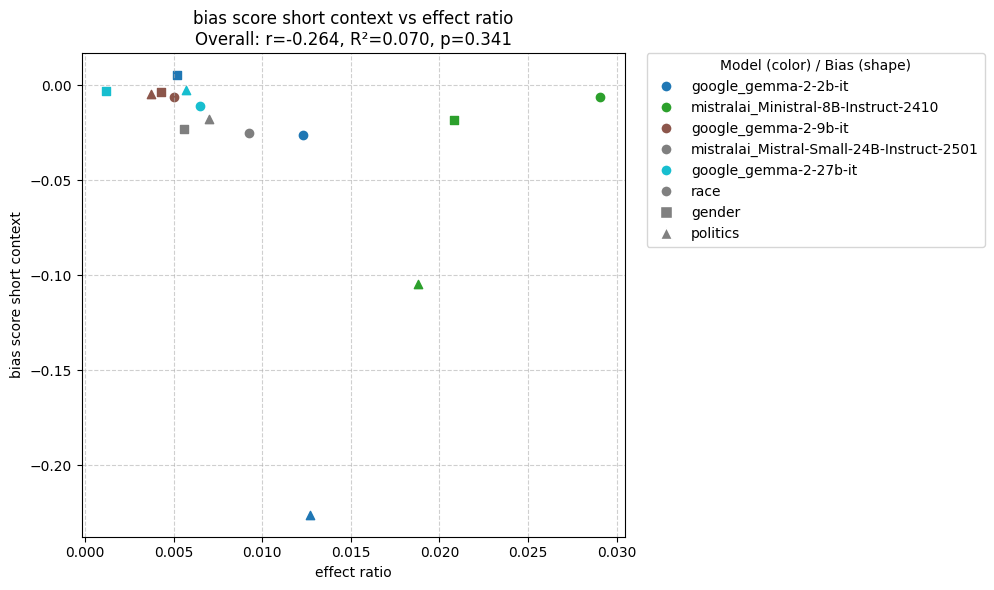

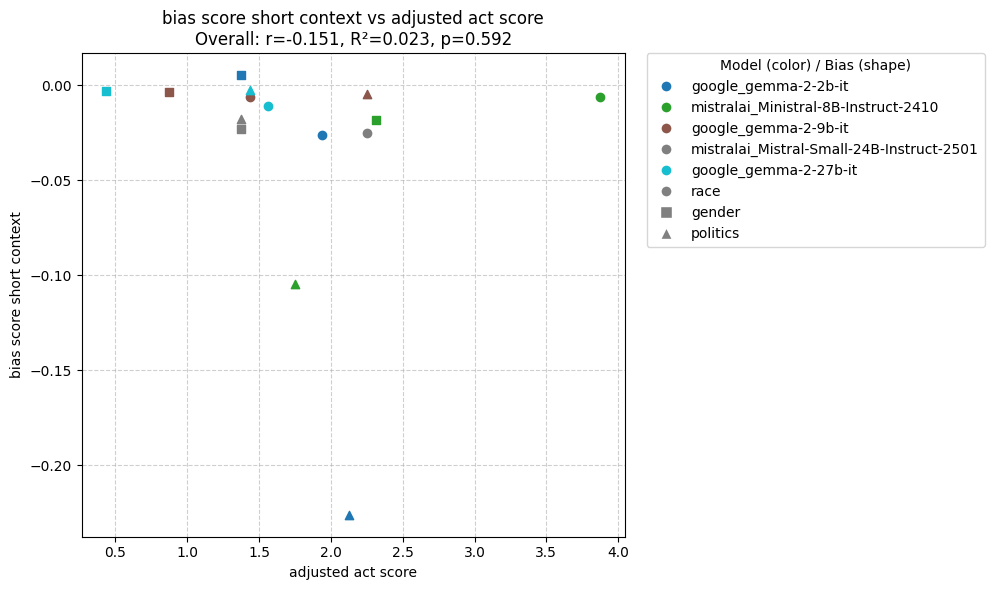

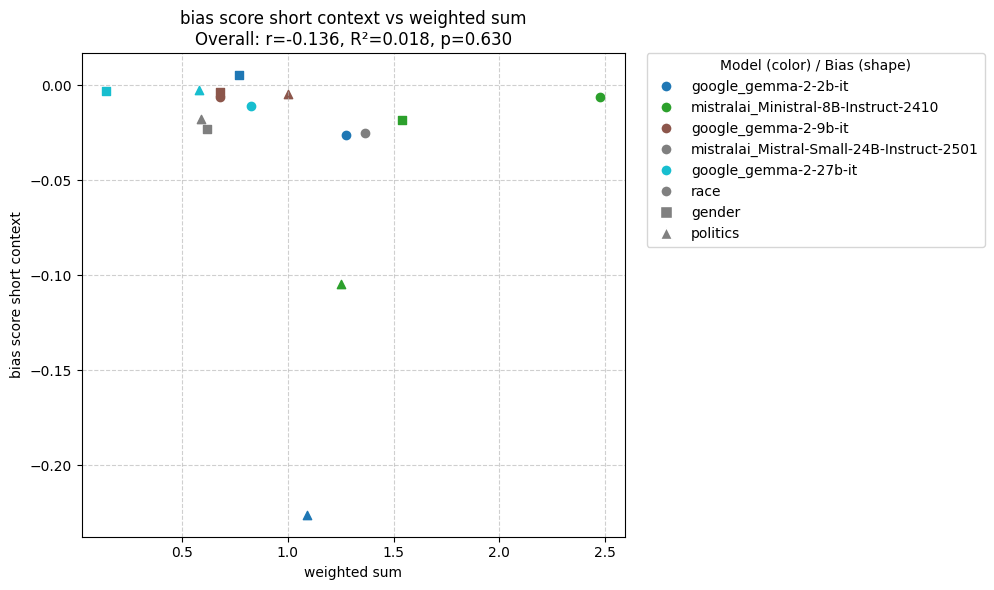

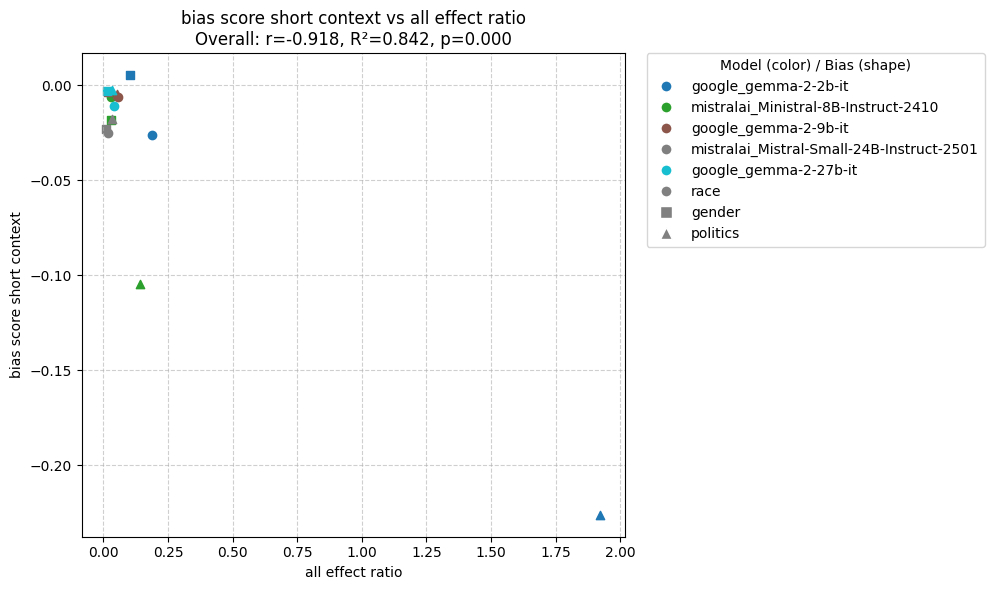

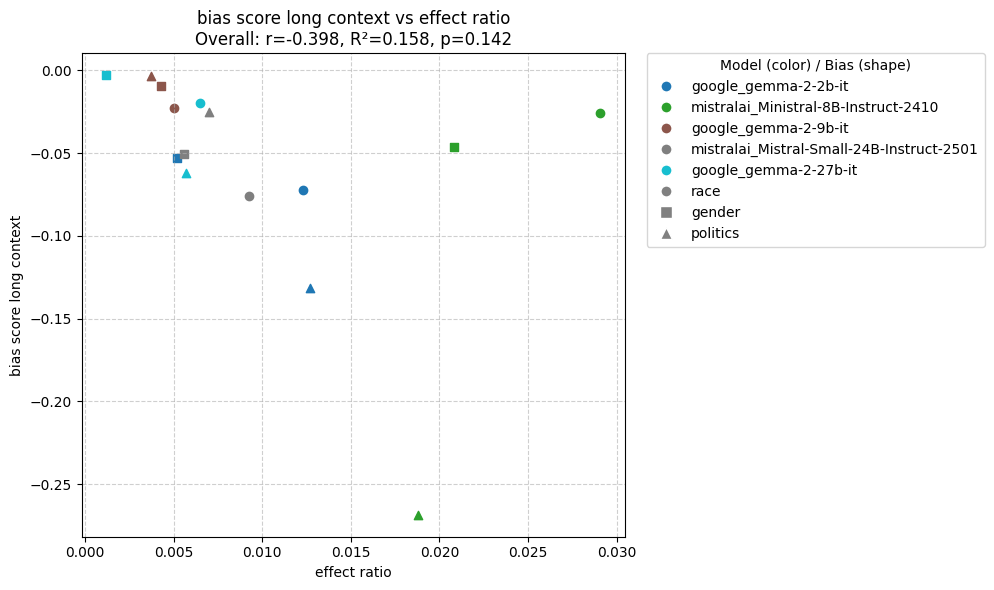

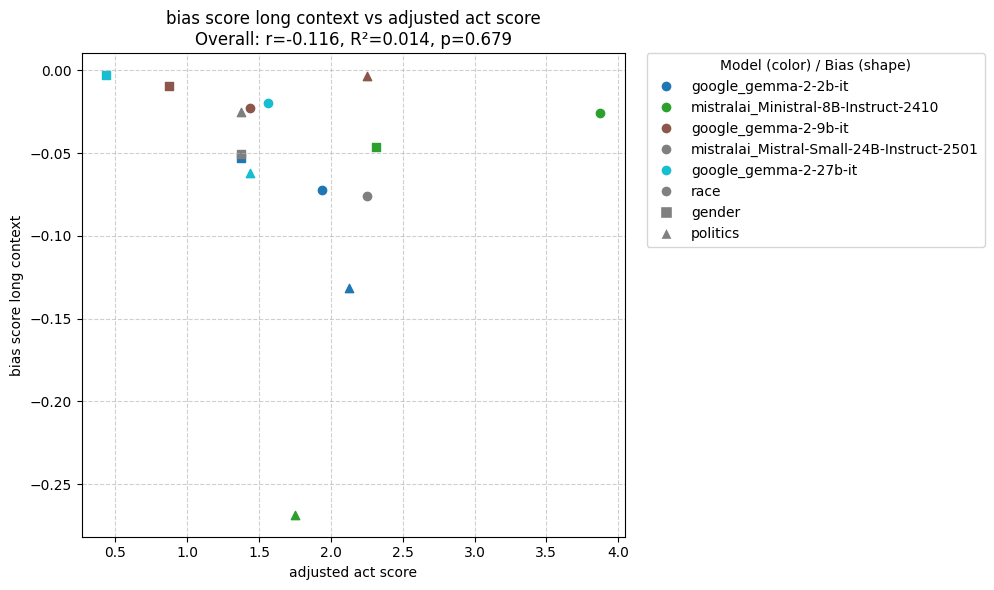

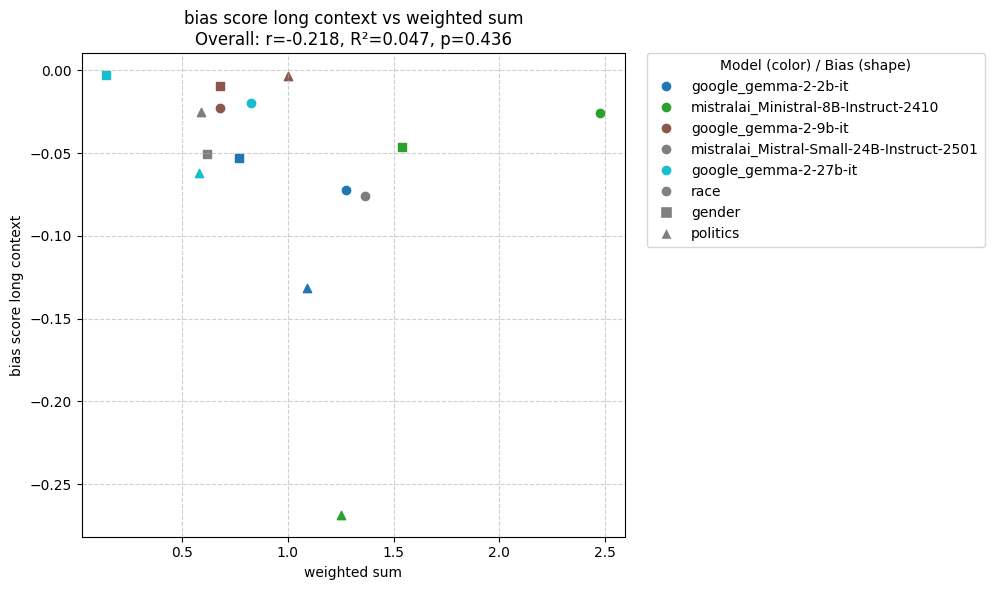

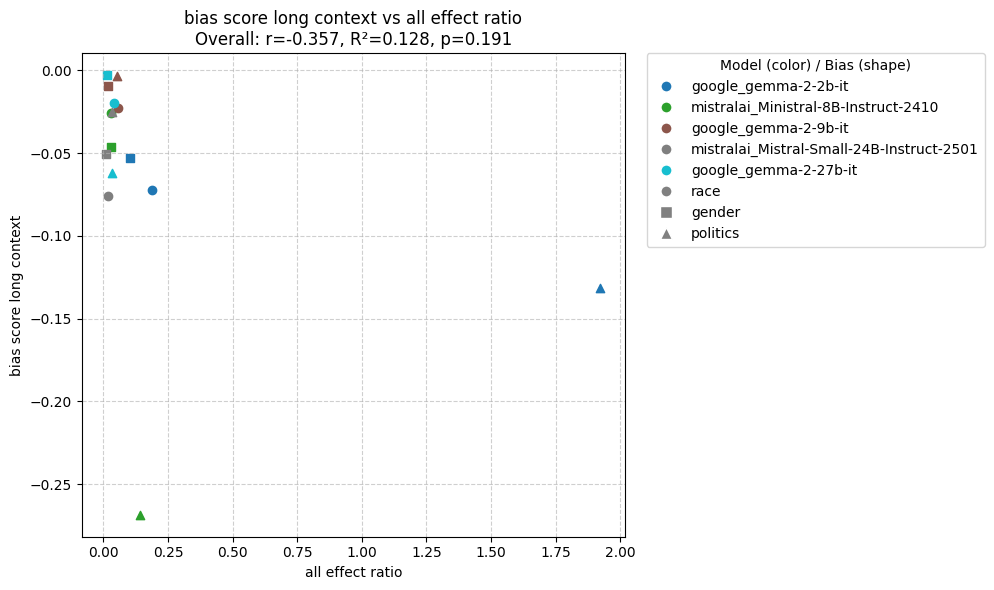

In [6]:
def plot_bias_df(bias_df: pd.DataFrame):
    # Define the pairs of columns to plot
    attribution_metrics = ["effect ratio", "adjusted act score", "weighted sum", "all effect ratio"]
    bias_scores = ["bias score short", "bias score long"]

    # Define colors for models and markers for bias types
    model_names = bias_df['Model name'].unique()
    bias_types = bias_df['bias type'].unique()

    # Use default color cycle and a standard set of markers
    colors = plt.cm.tab10(np.linspace(0, 1, len(model_names)))
    markers = ['o', 's', '^', 'D', 'v', '<', '>'] # Add more if needed

    color_map = {model: colors[i] for i, model in enumerate(model_names)}
    marker_map = {bias: markers[i % len(markers)] for i, bias in enumerate(bias_types)} # Cycle through markers if needed

    # Create the scatter plots
    for bias_score in bias_scores: # Iterate bias scores first (for Y-axis)
        for attrib_metric in attribution_metrics: # Iterate attribution metrics (for X-axis)

            plt.figure(figsize=(12, 6)) # Make figure wider to accommodate legend

            # Plot points for each model and bias type combination
            for model_name in model_names:
                for bias_type in bias_types:
                    # Filter data for the current combination
                    subset = bias_df[(bias_df['Model name'] == model_name) & (bias_df['bias type'] == bias_type)]
                    if not subset.empty:
                        plt.scatter(subset[attrib_metric], subset[bias_score],
                                    color=color_map[model_name],
                                    marker=marker_map[bias_type],
                                    label=f"{model_name} ({bias_type})" if bias_score == bias_scores[0] and attrib_metric == attribution_metrics[0] else "_nolegend_" # Only label once per series for a cleaner legend initially
                                ) # Use _nolegend_ trick for subsequent plots? No, let's try grouping labels.

            # Calculate overall correlation (ignoring model/bias distinctions for the title stat)
            x = bias_df[attrib_metric]
            y = bias_df[bias_score]
            # Ensure no NaN values interfere with correlation calculation
            valid_indices = ~np.isnan(x) & ~np.isnan(y)
            if np.any(valid_indices): # Check if there's any valid data to correlate
                r, p_value = stats.pearsonr(x[valid_indices], y[valid_indices])
                r_squared = r**2
                corr_text = f'Overall: r={r:.3f}, R²={r_squared:.3f}, p={p_value:.3f}'
            else:
                corr_text = 'Overall: No valid data for correlation'


            # Add labels and title
            plt.xlabel(attrib_metric)
            plt.ylabel(f"{bias_score} context")
            plt.title(f'{bias_score} context vs {attrib_metric}\n{corr_text}')
            plt.grid(True, linestyle='--', alpha=0.6)

            # Create custom legend handles for clarity
            # One handle per model (color) and one per bias type (marker)
            model_handles = [plt.Line2D([0], [0], marker='o', color='w', label=model,
                                    markerfacecolor=color_map[model], markersize=8)
                            for model in model_names]
            bias_handles = [plt.Line2D([0], [0], marker=marker_map[bias], color='w', label=bias,
                                    markerfacecolor='grey', markersize=8) # Use grey for marker-only legend items
                            for bias in bias_types]

            # Place legend outside the plot area
            plt.legend(handles=model_handles + bias_handles,
                    title="Model (color) / Bias (shape)",
                    bbox_to_anchor=(1.04, 1), # Position legend outside: (x, y), starting from lower-left
                    loc='upper left', # Anchor point of the legend box
                    borderaxespad=0.) # Padding between axes and legend border

            plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to prevent legend cutoff (rect=[left, bottom, right, top])
            plt.show()
plot_bias_df(bias_df)

In [8]:
# raise ValueError("Stop here")

In [21]:

model_name = "google_gemma-2-2b-it"
# model_name = "mistralai_Ministral-8B-Instruct-2410"
# model_name = "google_gemma-2-9b-it"
# model_name = "mistralai_Mistral-Small-24B-Instruct-2501"
model_name = "google_gemma-2-27b-it"

bias_score_path = f"data/cached_responses/0410_data_v2/score_output_0410/{model_name}"
attrib_path = f"attribution_results_data/{model_name}"

excluded_versions = [0, 17, 18, 19, 20]


bias_type = "race"
# bias_type = "gender"
bias_type = "politics"
bias_scores = get_bias_scores(bias_type, bias_score_path, excluded_versions)
# print(bias_scores)


attrib_ratios = get_attrib_ratios(bias_type, attrib_path, excluded_versions)
# print(attrib_ratios)

In [22]:
inspect_key = "3"

print(attrib_ratios.keys())
print(bias_scores.keys())
print(bias_scores[inspect_key]["long"])

print(attrib_ratios[inspect_key]["adjusted_act_ratios"])
print()

for key in attrib_ratios[inspect_key]:
    print(key, attrib_ratios[inspect_key][key])

dict_keys(['10', '11', '12', '13', '14', '15', '16', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'])
-0.03960000000000008
tensor([ 1.0000,  1.0002,  1.0015,  1.0003,  1.0016,  1.0013, 17.3813,  1.0028,
         1.0008,  1.0021,  1.0290,  1.0004,  1.0003,  1.0000,  1.0022,  1.0002,
         1.0002,  1.0014,  1.0029,  1.0002])

effects_F tensor([-1.4136e-06,  0.0000e+00,  0.0000e+00,  ...,  1.0044e-05,
        -2.3740e-06,  0.0000e+00])
top_k_vals tensor([ 0.0770, -0.0342,  0.0303, -0.0288, -0.0256, -0.0254,  0.0218,  0.0216,
        -0.0180,  0.0179,  0.0164, -0.0162,  0.0161,  0.0160, -0.0150,  0.0150,
         0.0134, -0.0134, -0.0133, -0.0130])
top_k_ids tensor([ 15525,  75298,  86677,  32581, 111910,  80263,  57768, 128587, 129659,
        128060, 130860, 126088,  73800,  87077, 103740,  48599,  20772,  55650,
         87096,  95035])
adjusted_act_ratios tensor([ 1.0000,  1.0002,  1.0015

In [23]:
def create_prompt_df(bias_type: str, model_name: str, excluded_versions: list[int]) -> pd.DataFrame:
    bias_score_path = f"data/cached_responses/0410_data_v2/score_output_0410/{model_name}"
    attrib_path = f"attribution_results_data/{model_name}"

    bias_scores = get_bias_scores(bias_type, bias_score_path, excluded_versions)
    attrib_ratios = get_attrib_ratios(bias_type, attrib_path, excluded_versions)

    data_list = []

    for version in attrib_ratios.keys():
        # Create a dictionary for the current row
        row_data = {
            "bias score short": bias_scores[version]["short"],
            "bias score long": bias_scores[version]["long"],
            "effect ratio": attrib_ratios[version]["effect_ratio"],
            "adjusted act score": attrib_ratios[version]["adjusted_act_score"],
            "weighted sum": attrib_ratios[version]["weighted_sum"],
            "all effect ratio": attrib_ratios[version]["all_effect_ratio"]
        }
        # Append the dictionary to the list
        data_list.append(row_data)

    prompt_df = pd.DataFrame(data_list)

    return prompt_df

# prompt_df = create_prompt_df("race", "google_gemma-2-2b-it", excluded_versions)
prompt_df = create_prompt_df("politics", "google_gemma-2-27b-it", excluded_versions)
print(prompt_df.head())

   bias score short  bias score long  effect ratio  adjusted act score  \
0            0.0104          -0.0187      0.003554                   1   
1           -0.0041          -0.2125      0.004167                   1   
2           -0.0146          -0.1584      0.004358                   1   
3            0.0000          -0.0854      0.009599                   2   
4           -0.0063          -0.0042      0.009014                   2   

   weighted sum  all effect ratio  
0      0.348678          0.014025  
1      0.387420          0.026354  
2      0.590490          0.027413  
3      0.841402          0.015315  
4      0.939168          0.019555  


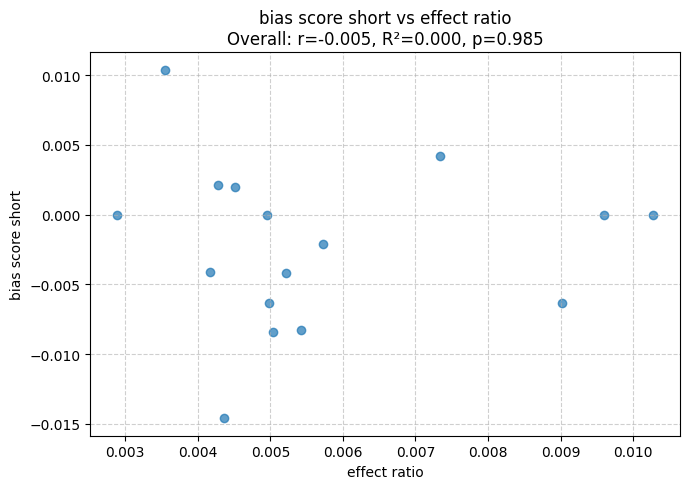

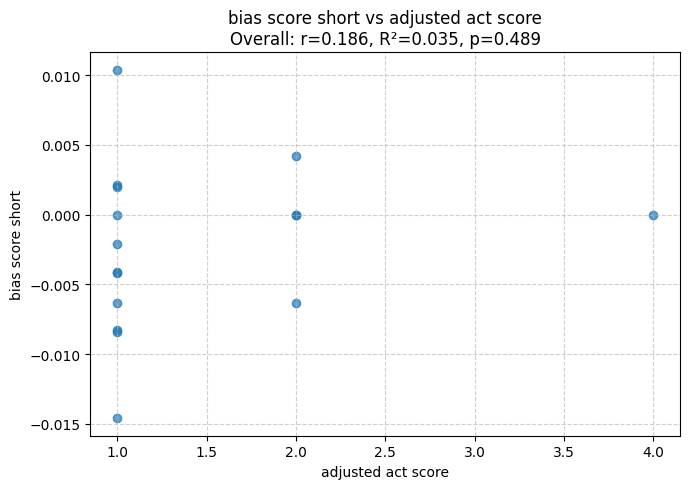

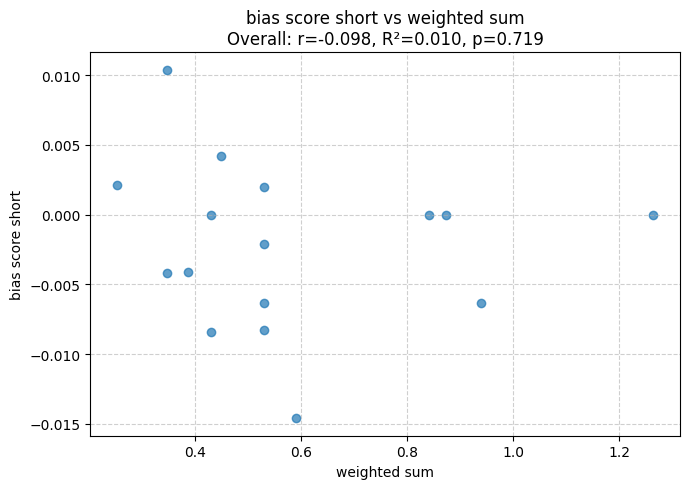

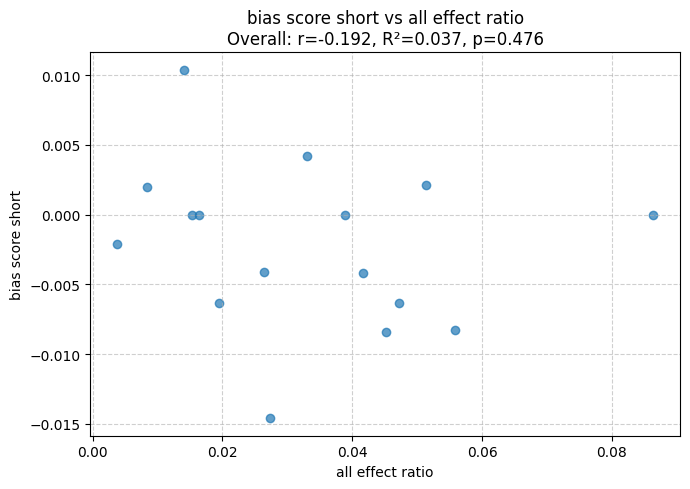

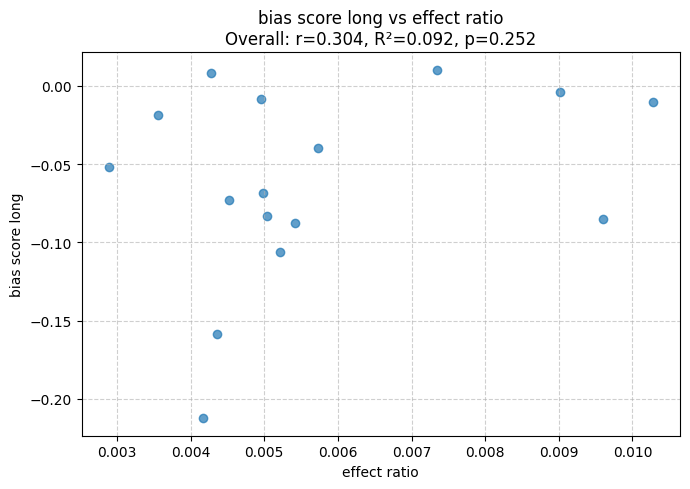

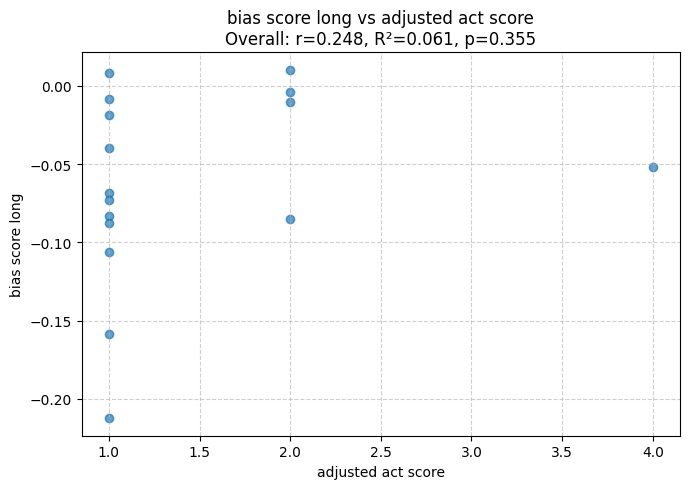

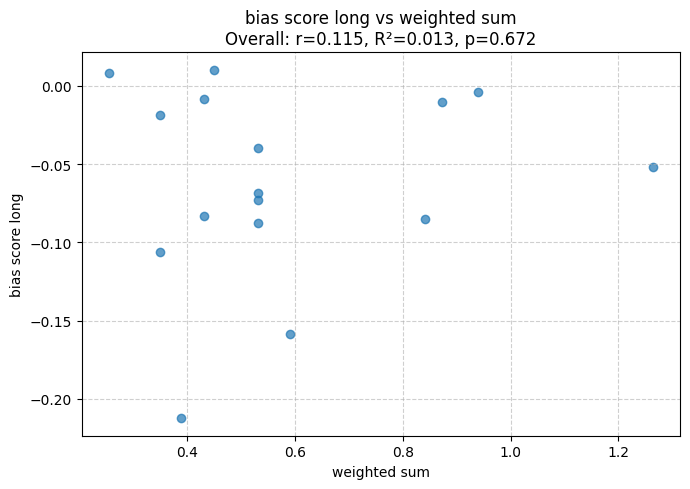

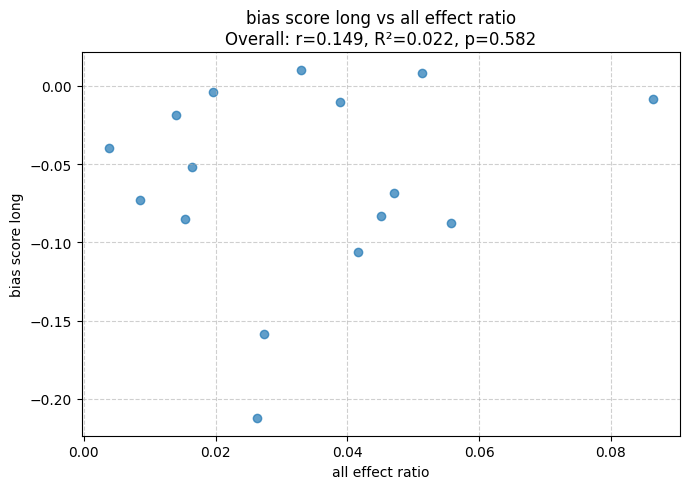

In [24]:
def plot_prompt_level_bias(bias_df: pd.DataFrame):
    """
    Generates scatter plots for prompt-level data, comparing bias scores
    against attribution metrics for a single model/bias type.

    Args:
        bias_df: DataFrame where each row is a prompt, containing bias scores
                 and attribution metrics. Assumed to be for a single model/bias type.
    """
    # Define the columns to plot
    # Ensure 'all effect ratio' exists in your DataFrame
    attribution_metrics = ["effect ratio", "adjusted act score", "weighted sum", "all effect ratio"]
    bias_scores = ["bias score short", "bias score long"]

    # Filter out metrics not present in the DataFrame to avoid errors
    attribution_metrics = [m for m in attribution_metrics if m in bias_df.columns]
    if not attribution_metrics:
        print("Error: None of the specified attribution metrics found in the DataFrame columns.")
        return

    # Create the scatter plots
    for bias_score in bias_scores:
        if bias_score not in bias_df.columns:
            print(f"Warning: Bias score column '{bias_score}' not found. Skipping plots for it.")
            continue

        for attrib_metric in attribution_metrics:
            plt.figure(figsize=(7, 5)) # Adjusted figure size

            x = bias_df[attrib_metric]
            y = bias_df[bias_score]

            # Plot points directly - no need for model/bias grouping
            plt.scatter(x, y, alpha=0.7) # Added alpha for potential overlaps

            # Calculate overall correlation
            # Ensure no NaN values interfere with correlation calculation
            valid_indices = ~np.isnan(x) & ~np.isnan(y)
            if np.any(valid_indices) and len(x[valid_indices]) > 1: # Need at least 2 points for correlation
                try:
                    r, p_value = stats.pearsonr(x[valid_indices], y[valid_indices])
                    r_squared = r**2
                    corr_text = f'Overall: r={r:.3f}, R²={r_squared:.3f}, p={p_value:.3f}'
                except ValueError as e:
                    corr_text = f'Overall: Correlation error ({e})' # Handle potential errors like zero variance
            else:
                corr_text = 'Overall: Not enough valid data for correlation'

            # Add labels and title
            plt.xlabel(attrib_metric)
            plt.ylabel(bias_score)
            plt.title(f'{bias_score} vs {attrib_metric}\n{corr_text}')
            plt.grid(True, linestyle='--', alpha=0.6)

            # No complex legend needed now
            plt.tight_layout() # Adjust layout automatically
            plt.show()

plot_prompt_level_bias(prompt_df)

In [25]:
# attrib_files = sorted([f for f in os.listdir(attrib_path) if "layer_25" in f])

# first_file = attrib_files[0]

# filename = os.path.join(attrib_path, first_file)

# data = torch.load(filename)

# torch.set_printoptions(precision=5, sci_mode=False)

# # print(data)
# attribution_data = AttributionData.from_dict(data["race"])

# effects_F = attribution_data.pos_effects_F - attribution_data.neg_effects_F

# k = 20

# top_k_ids = effects_F.abs().topk(k).indices
# top_k_vals = effects_F[top_k_ids]

# print(top_k_ids)
# print(top_k_vals)

# effect_ratios = attribution_data.pos_effects_F / attribution_data.neg_effects_F

# print(attribution_data.pos_effects_F[top_k_ids])
# print(attribution_data.neg_effects_F[top_k_ids])
# print(effect_ratios[top_k_ids])

# act_diff_F = attribution_data.pos_sae_acts_F - attribution_data.neg_sae_acts_F

# print(act_diff_F[top_k_ids])

# acts_ratio_F = attribution_data.pos_sae_acts_F / attribution_data.neg_sae_acts_F

# print(acts_ratio_F[top_k_ids])

# adjusted_acts_ratio_F = adjust_tensor_values(acts_ratio_F[top_k_ids])





In [26]:
# print(adjust_tensor_values(acts_ratio_F[top_k_ids]))